# Описание

В эпоху стремительного развития нейросетевых технологий и широкого распространения нейросетей для генерации изображений, возникает все больше проблем с распознаванием подлинности фотографий.

Фейковые фотографии, созданные с помощью современных инструментов искусственного интеллекта, становятся все более реалистичными и сложными для обнаружения.

В этом проекте мы используем глубокое обучение на основе фреймворка Keras в Kaggle, чтобы создать модель, способную эффективно различать реальные фотографии людей и их фейковые аналоги.

Данная модель может быть применена в различных областях, где требуется достоверная идентификация изображений, таких как системы авторизации, социальные сети и достоверные медиа.

Для текущей задачи выбран датасет Real vs Fake Faces - 10k (взятый с Kaggle), который основан на более крупном датасете 140k Real and Fake Faces.

In [1]:
# Импорт необходимых библиотек

import gdown
from zipfile import ZipFile
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Input, Dense, Dropout, Flatten, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [ ]:
gdown.download('https://drive.google.com/uc?export=download&id=1Jr0hZYwu_dUADSzcoqzo967nS-AVgfoc')

zip_path = "/content/RVFF_10K.zip"
extract_path = "/content/Dataset/"

with ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

In [3]:
# Загрузка данных
train_df = pd.read_csv('/content/Dataset/train.csv', index_col=0)
valid_df = pd.read_csv('/content/Dataset/valid.csv', index_col=0)

train_df = train_df.drop('original_path', axis=1)
valid_df = valid_df.drop('original_path', axis=1)

train_df['id_ext'] = train_df['id'] + '.jpg'
valid_df['id_ext'] = valid_df['id'] + '.jpg'

train_df['label'] = train_df['label'].astype(str)
valid_df['label'] = valid_df['label'].astype(str)

In [ ]:
train_df.head()

In [ ]:
train_df.info()

In [ ]:
# Создание генераторов данных
train_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory='/content/Dataset/train',
    x_col='id_ext',
    y_col='label',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

valid_generator = valid_datagen.flow_from_dataframe(
    dataframe=valid_df,
    directory='/content/Dataset/valid',
    x_col='id_ext',
    y_col='label',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

In [7]:
# Создание модели
model = Sequential()

# Входной слой
model.add(Input(shape=(224, 224, 3)))

# Первый блок свертки
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

# Второй блок свертки
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

# Третий блок свертки
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

# Полносвязные слои
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))  # Добавлен промежуточный слой
model.add(Dropout(0.2))  # Добавлен dropout для промежуточного слоя

# Выходной слой
model.add(Dense(1, activation='sigmoid'))

# Компиляция модели
model.compile(optimizer=Adam(learning_rate=0.001),  # Используем оптимизатор Adam
              loss='binary_crossentropy',  # Функция потерь для бинарной классификации
              metrics=['accuracy'])  # Метрика для оценки модели

In [ ]:
# Обучение модели
test_model = model.fit(
    train_generator,
    epochs=10,
    validation_data=valid_generator,
    verbose=1
)

# Вывод точности модели
train_accuracy = test_model.history['accuracy'][-1]  # Точность на обучающем наборе
val_accuracy = test_model.history['val_accuracy'][-1]  # Точность на валидационном наборе

print(f"Точность на обучающем наборе: {train_accuracy:.2f}")
print(f"Точность на валидационном наборе: {val_accuracy:.2f}")

In [9]:
def plot_metrics(train_metric, val_metric, metric_type):
    # Визуализация показателей за несколько эпох
    plt.figure(figsize=(12, 6))
    plt.plot(range(len(train_metric)), train_metric, label=f"{metric_type} на обучающей выборке")
    plt.plot(range(len(val_metric)), val_metric, label=f"{metric_type} на валидационной выборке")
    plt.xlabel("Эпохи")
    plt.ylabel(metric_type)
    plt.legend()
    plt.title(f"{metric_type} от эпохи")

In [10]:
train_accuracy = test_model.history['accuracy']
val_accuracy = test_model.history['val_accuracy']
train_loss = test_model.history['loss']
val_loss = test_model.history['val_loss']

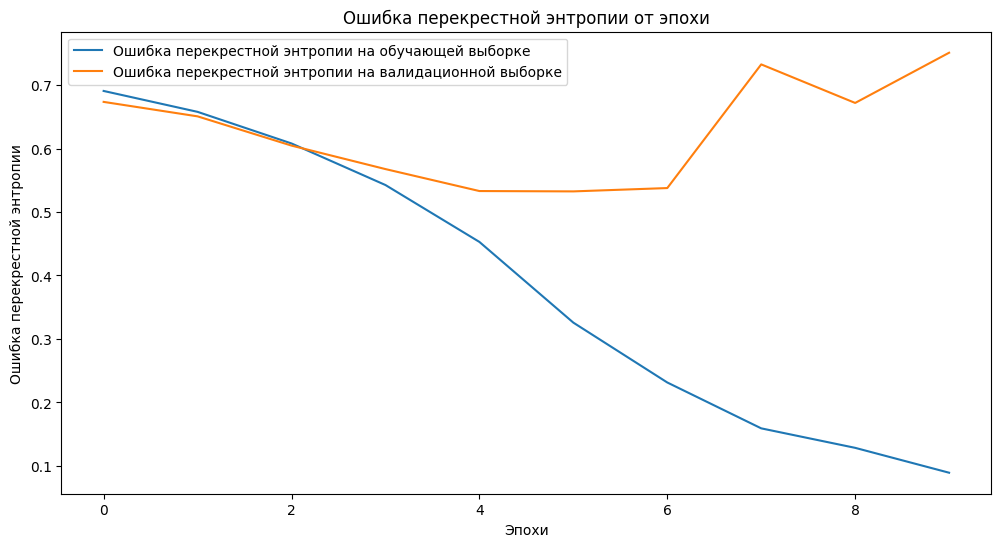

In [11]:
plot_metrics(train_loss, val_loss, "Ошибка перекрестной энтропии")

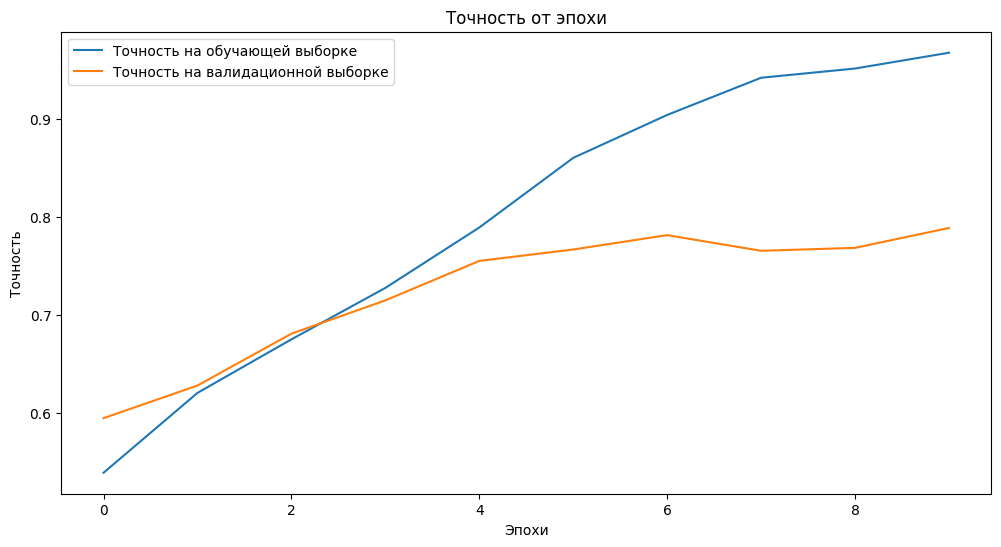

In [12]:
plot_metrics(train_accuracy, val_accuracy, "Точность")

In [ ]:
# Извлечение предсказаний и истинных меток классов только для доступных образцов
num_samples = len(valid_generator)  # Общее количество образцов
batch_size = valid_generator.batch_size

predictions = []
y_true = []

for i in range(num_samples):
    batch_images, batch_labels = valid_generator[i]
    batch_predictions = model.predict(batch_images)
    predictions.extend(batch_predictions)
    y_true.extend(batch_labels)

predictions = np.array(predictions).reshape(-1, 1)
y_true = np.array(y_true)

# Преобразование предсказаний в метки классов
y_pred = (predictions > 0.5).astype(int)

# Создание матрицы ошибок
conf_matrix = confusion_matrix(y_true, y_pred)

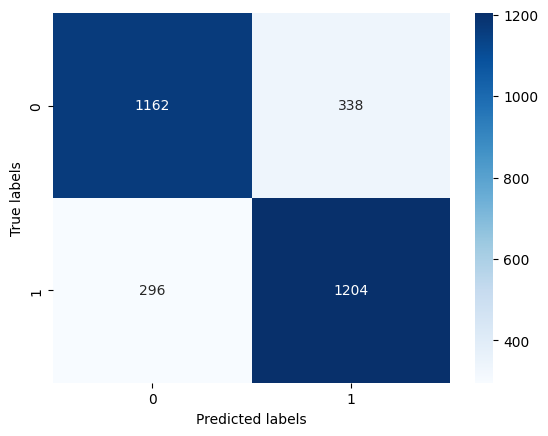

In [14]:
# Построение матрицы ошибок
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

In [15]:
# Сохранение модели
model.save('test_model_v1.keras')

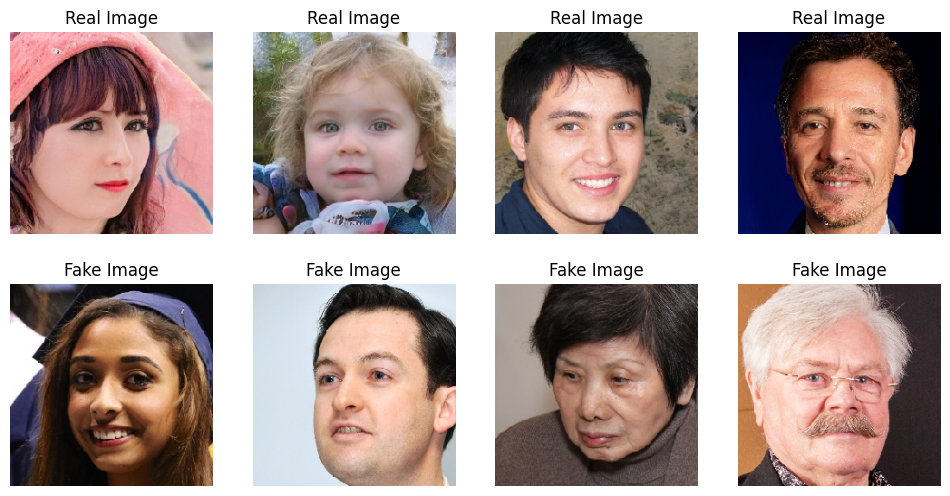

In [16]:
# Получение 4 реальных и 4 фейковых изображений из valid_generator
real_images = []
fake_images = []
for i in range(8):  # Получаем 8 изображений
    images, labels = next(valid_generator)
    for j in range(len(labels)):
        if labels[j] == 0 and len(real_images) < 4:  # 0 - метка для реальных изображений
            real_images.append(images[j])
        elif labels[j] == 1 and len(fake_images) < 4:  # 1 - метка для фейковых изображений
            fake_images.append(images[j])

# Отображение изображений
plt.figure(figsize=(12, 6))
for i in range(4):
    plt.subplot(2, 4, i + 1)
    plt.imshow(real_images[i])
    plt.title('Real Image')
    plt.axis('off')

    plt.subplot(2, 4, i + 5)
    plt.imshow(fake_images[i])
    plt.title('Fake Image')
    plt.axis('off')

plt.show()

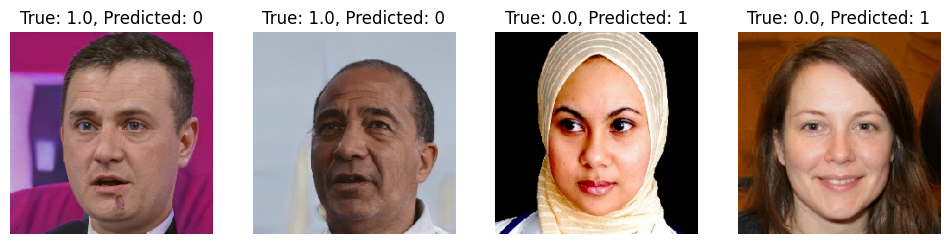

In [17]:
# Находим индексы изображений, на которых модель сделала ошибку
incorrect_indices = [i for i, (true, pred) in enumerate(zip(y_true, y_pred)) if true != pred]

# Отображаем первые 4 изображения, на которых модель ошиблась
plt.figure(figsize=(12, 6))
for i, idx in enumerate(incorrect_indices[:4]):
    image = valid_generator[idx][0][0]  # Получаем изображение по индексу
    plt.subplot(1, 4, i + 1)
    plt.imshow(image)
    plt.title(f"True: {y_true[idx]}, Predicted: {y_pred[idx][0]}")
    plt.axis('off')

plt.show()

Заключение:

Результаты обучения показали, что модель достигла точности в районе 80%, что является хорошим показателем.

Некоторые фейковые фотографии настолько реалистичны, что даже человеку сложно отличить их от настоящих. Это подчеркивает важность развития более продвинутых методов и технологий для борьбы с фейковыми изображениями.

Использование расширенного датасета, такого как 140k Real and Fake Faces, может значительно улучшить модель, однако, для этого потребуются значительные вычислительные ресурсы и временные затраты. В дальнейшем, работа с более крупными и разнообразными наборами данных может повысить эффективность модели и улучшить ее способность к распознаванию фейковых изображений.